#### **0. References**

1. The model implementation is primarily based on the official [MAE repository](https://github.com/facebookresearch/mae) by Facebook Research and the [GSOC 2024 project](https://github.com/ML4SCI/E2E/tree/main/Masked_AutoEncoders_E2E_GSCO24_Shashank_Shukla) by Shashank Shekhar Shukla for the E2E organization.

2. The original model utilizes a Base-ViT architecture, which is considerably large given our limited dataset. To address this, we followed the approach from this [Kaggle notebook](https://www.kaggle.com/code/spsayakpaul/mae-keras) by Sayak Paul and Aritra Roy to reduce the model size.

3. **ChatGPT**: acting as the masked autoencoder for my masked understanding.


#### **1. Libraries**

In [ ]:
## Importing libraries ##
# Standard Library
import os
import sys
import time
import random
import pathlib
from collections import Counter
from functools import partial
import sys

# Scientific & Plotting Libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Progress Bar
from tqdm import tqdm

# PyTorch Core
import torch
import torch.nn as nn

# PyTorch Utilities
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

# Vision Transformer from timm
from timm.models.vision_transformer import PatchEmbed, Block


In [67]:
## GPU check and version check ##
!nvidia-smi --query-gpu=name,memory.total --format=csv,noheader
print( 'python version : ',sys.version) 
print( 'torch version  : ',torch.__version__)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

NVIDIA GeForce RTX 4070 Ti SUPER, 16376 MiB
python version :  3.12.8 | packaged by conda-forge | (main, Dec  5 2024, 14:06:27) [MSC v.1942 64 bit (AMD64)]
torch version  :  2.5.1+cu121


#### **2. General utils**

In [4]:
## utility functions ##
def set_seed(seed):
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True # only applies to CUDA convolutional operation.
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.use_deterministic_algorithms(True,warn_only=True)

def get_class_distribution(dataset, class_to_idx):
    """Returns the class distribution as a sorted dictionary by class names"""
    idx_to_class = {v: k for k, v in class_to_idx.items()}  # Reverse mapping
    labels = [label.item() for _, label in dataset]  # Extract labels
    class_counts = Counter(labels)  # Count occurrences

    return {idx_to_class[k]: class_counts[k] for k in sorted(class_counts.keys(), key=lambda x: idx_to_class[x])}



def plot_loss(train_loss, val_loss, save_path="figures/loss_curve.png"):
    # Set plot style within the function (local to this plot only)
    sns.set(style='whitegrid', context='paper', font_scale=1.4, rc={'axes.edgecolor': 'black', 'axes.linewidth': 1.2})
    plt.rc('font', family='serif', size=12)

    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(8, 6), dpi=300)

    # Define visually appealing colors
    colors = ['crimson', 'navy']

    plt.plot(epochs, train_loss, label=f"Training Loss", color=colors[0], linewidth=2.5)
    plt.plot(epochs, val_loss, label=f"Validation Loss", color=colors[1], linewidth=2.5, linestyle='--')

    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.title('Training and Validation Loss', fontsize=16, fontweight='bold')

    plt.legend(loc="upper right", fontsize=11, frameon=True, shadow=True)

    plt.grid(alpha=0.3)

    # Adjust axis limits dynamically with margin
    all_losses = train_loss + val_loss
    min_loss, max_loss = min(all_losses), max(all_losses)
    margin = (max_loss - min_loss) * 0.1
    plt.ylim(min_loss - margin, max_loss + margin)

    plt.tight_layout()

    # Create directory if it doesn't exist
    dir_name = os.path.dirname(save_path)
    if dir_name and not os.path.exists(dir_name):
        os.makedirs(dir_name)

    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def display_prediction(model, class_dir, mean, std, device, colormap='viridis',  save_path="figures/prediction.png"):
    
    # Set plot style within the function (local to this plot only)
    sns.set(style='white', context='paper', font_scale=1.8, 
            rc={'axes.edgecolor': 'black', 'axes.linewidth': 2})
    plt.rc('font', family='serif', size=16)
    
    random_file = np.random.choice(os.listdir(class_dir))
    img_ex = np.load(os.path.join(class_dir, random_file))

    epsilon = 1e-8
    img_ex = (img_ex - mean) / (std + epsilon)
    img_ex = torch.from_numpy(img_ex).float()  # (64,64)
    img_ex = img_ex.unsqueeze(0).unsqueeze(0).to(device)  # (1,1,64,64)

    model.eval()
    with torch.no_grad():
        imgs, pred, mask = model(img_ex)
    
    # imgs (B, num_patches, patch_size**2 * in_chans), 
    # pred (B, num_patches, patch_size**2 * in_chans),
    # mask (B, num_patches)
    # num_patches = (H*W)/(patch_size**2)

    imgs = model.encoder.unpatchify(imgs)  # (B,C,H,W)
    pred = model.encoder.unpatchify(pred)  # (B,C,H,W)

    imgs = imgs.squeeze().cpu().numpy()
    pred = pred.squeeze().cpu().numpy()
    mask = mask.squeeze().cpu().numpy()  # Mask shape (num_patches)

    # Reshape mask to match image dimensions
    patch_size = int(np.sqrt(imgs.shape[0] * imgs.shape[1] / mask.shape[0]))  # Assuming square patches
    mask = mask.reshape(imgs.shape[0] // patch_size, imgs.shape[1] // patch_size)  # Reshape mask to match patch grid
    mask = np.kron(mask, np.ones((patch_size, patch_size)))  # Upscale mask

    # Apply mask to the input image (masked image)
    masked_img = imgs * (1 - mask)

    fig, axes = plt.subplots(1, 3, figsize=(21, 7), dpi=1000)

    cmap_list = [colormap, colormap, colormap]
    titles = ['Original Image', 'Masked Image', 'Predicted Reconstruction']
    images = [imgs, masked_img, pred]

    for ax, img, title, cmap in zip(axes, images, titles, cmap_list):
        im = ax.imshow(img, cmap=cmap)
        ax.set_title(title, fontsize=18, fontweight='bold')
        ax.axis('on')
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    plt.tight_layout()


    dir_name = os.path.dirname(save_path)
    if dir_name and not os.path.exists(dir_name):
        os.makedirs(dir_name)

    fig.savefig(save_path, dpi=1000, bbox_inches='tight')
    plt.show()


#### **3. Training utils** 

In [69]:
def custom_loss(imgs, pred, mask):
    """
    imgs (B, num_patches, patch_size**2 * in_chans),
    pred (B, num_patches, patch_size**2 * in_chans),
    mask (B, num_patches)
    """
    target = imgs
    loss = (pred - target) ** 2
    loss = loss.mean(dim=-1)  # [B, num_patches], mean loss per patch

    loss = (loss * mask).sum() / mask.sum()  # mean loss on removed patches
    return loss


class Trainer_pretrain:
    def __init__(self, model, device, HP ):
        self.model = model
        self.device =device
        self.epochs = HP['num_epochs']
        self.batch_size = HP['batch_size']
        self.lr = HP['lr']
    
    def model_train(self, train_dataloader, val_dataloader):

        optimizer = AdamW(self.model.parameters(), lr=1.5e-4, weight_decay=0.05)
        scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=40, T_mult=2)

        train_losses = []
        val_losses = []

        for epoch in range(self.epochs):
            train_loss = 0.0
            val_loss = 0.0

            # setting the model to train mode 
            # this is required because some layers like dropout, batchnorm etc behave differently
            # in train and eval mode
            self.model.train()
            for images in tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{self.epochs} (Train)', unit='batch'):
                images = images[0].to(self.device).float()

                # resettuing the gradients to zero
                optimizer.zero_grad() 
                # forward pass
                imgs, outputs, ind = self.model(images)
                # calculating the loss
                loss = custom_loss(imgs, outputs, ind)
                # backward pass to calculate the gradients
                loss.backward()
                # updating the weights
                optimizer.step()

                train_loss += loss.item()

            train_loss /= len(train_dataloader)
            train_losses.append(train_loss)

            # setting the model to eval mode
            self.model.eval()

            # we don't need to calculate the gradients in the validation phase
            with torch.no_grad():
                for images in tqdm(val_dataloader, desc=f'(Val)', unit='batch'):
                    images = images[0].to(self.device).float()
                    
                    # forward pass  
                    imgs, val_outputs, ind = self.model(images)
                    # calculating the loss
                    loss = custom_loss(imgs, val_outputs, ind)

                    val_loss += loss.item()

            val_loss /= len(val_dataloader)
            val_losses.append(val_loss)

            scheduler.step()

            print(f'Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}\n')
            with open('losses.txt', 'a') as f:  # Open file in append mode
                f.write(f'Epoch {epoch+1}/{self.epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}\n')

        return train_losses, val_losses

#### **4. Model utils**

A Masked Autoencoder (MAE) is a self-supervised model that learns by masking a large portion (e.g., 75%) of an input image and training itself to reconstruct the missing parts. It uses a Vision Transformer (ViT) encoder to process only the visible patches and a decoder to reconstruct the full image from the encoded features and masked patch positions. MAEs are efficient i.e dont need much data augmentation unlike other self supervised learning frameworks, label-free, and useful for tasks like image classification and super-resolution. Given below is the simplified architecture diagram,

<div align="center">
  <img src="figures/MAE.jpg" alt="MAE" width="500"/>
</div>

Image source : (https://github.com/ML4SCI/E2E/tree/main/Masked_AutoEncoders_E2E_GSCO24_Shashank_Shukla)

In [ ]:
## Model defenition ##

def get_2d_sincos_pos_embed(embed_dim, grid_size, cls_token=False): 
    """
    grid_size: int of the grid height and width
    return:
    pos_embed: [grid_size*grid_size, embed_dim] or [1+grid_size*grid_size, embed_dim] (w/ or w/o cls_token)
    """
    grid_h = np.arange(grid_size, dtype=np.float32)
    grid_w = np.arange(grid_size, dtype=np.float32)
    grid = np.meshgrid(grid_w, grid_h)  # here w goes first
    grid = np.stack(grid, axis=0)

    grid = grid.reshape([2, 1, grid_size, grid_size])
    pos_embed = get_2d_sincos_pos_embed_from_grid(embed_dim, grid)
    if cls_token:
        pos_embed = np.concatenate([np.zeros([1, embed_dim]), pos_embed], axis=0)
    return pos_embed

def get_2d_sincos_pos_embed_from_grid(embed_dim, grid): 
    assert embed_dim % 2 == 0

    # use half of dimensions to encode grid_h
    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0])  # (H*W, D/2)
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])  # (H*W, D/2)

    emb = np.concatenate([emb_h, emb_w], axis=1) # (H*W, D)
    return emb

def get_1d_sincos_pos_embed_from_grid(embed_dim, pos): 
    """
    embed_dim: output dimension for each position
    pos: a list of positions to be encoded: size (M,)
    out: (M, D)
    """
    assert embed_dim % 2 == 0
    omega = np.arange(embed_dim // 2, dtype='float32')
    omega /= embed_dim / 2.
    omega = 1. / 10000**omega  # (D/2,)

    pos = pos.reshape(-1)  # (M,)
    out = np.einsum('m,d->md', pos, omega)  # (M, D/2), outer product

    emb_sin = np.sin(out) # (M, D/2)
    emb_cos = np.cos(out) # (M, D/2)

    emb = np.concatenate([emb_sin, emb_cos], axis=1)  # (M, D)
    return emb

class Encoder( nn.Module ):
    def __init__(self, img_size=224, patch_size=16, in_chans=3,
                 embed_dim=1024, depth=24, num_heads=16,
                 decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16,
                 mlp_ratio=4., norm_layer=nn.LayerNorm, norm_pix_loss=False): # unchanged param values
        
        super().__init__()

        ## MAE Encoder specifics ##

        self.mask_ratio = 0.75
        self.in_chans = in_chans    
        self.patch_embed = PatchEmbed(img_size, patch_size, in_chans, embed_dim)
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim), requires_grad=False)

        self.blocks = nn.ModuleList([
            Block(embed_dim, num_heads, mlp_ratio, qkv_bias=True, norm_layer=norm_layer)
            for i in range(depth)])

        self.norm = norm_layer(embed_dim)

        self.initialize_weights()

    def initialize_weights(self):
        # initialization
        # initialize (and freeze) pos_embed by sin-cos embedding
        pos_embed = get_2d_sincos_pos_embed(self.pos_embed.shape[-1], int(self.patch_embed.num_patches**.5), cls_token=True)
        self.pos_embed.data.copy_(torch.from_numpy(pos_embed).float().unsqueeze(0))

        # initialize patch_embed like nn.Linear (instead of nn.Conv2d)
        w = self.patch_embed.proj.weight.data
        torch.nn.init.xavier_uniform_(w.view([w.shape[0], -1]))

        # timm's trunc_normal_(std=.02) is effectively normal_(std=0.02) as cutoff is too big (2.)
        torch.nn.init.normal_(self.cls_token, std=.02)

        # initialize nn.Linear and nn.LayerNorm
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            # we use xavier_uniform following official JAX ViT:
            torch.nn.init.xavier_uniform_(m.weight)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def patchify(self, imgs): # checked
        """
        imgs: (B, C, H, W)
        x: (B, seq_len, d_model) 

        seq_len = H*W / p**2 
        d_model = p**2 * C
        """
        B,C,H,W = imgs.shape # (B, C, H, W)
        p = self.patch_embed.patch_size[0]
        assert H == W and H % p == 0

        h = w = imgs.shape[2] // p
        x = imgs.reshape(shape=(B, C, h, p, w, p)) # (B, C, h, p, w, p)
        x = torch.einsum('bchpwq->bhwpqc', x) # (B, h, w, p, p, C)
        x = x.reshape(shape=(B, h * w, p**2 * C)) # (B, seq_len, d_model)
        return x # (B, seq_len, d_model)
    
    def unpatchify(self, x): # checked 
        """
        x: (B, seq_len, d_model) 
        imgs: (B, 8, H, W)

        seq_len = H*W / p**2
        d_model = p**2 * C
        """
        B,seq_len, d_model = x.shape     
        C = self.in_chans   

        p = self.patch_embed.patch_size[0]
        h = w = int(seq_len**.5)
        assert h * w == seq_len
        
        x = x.reshape(shape=(B, h, w, p, p, C)) # (B, h, w, p, p, C)
        x = torch.einsum('nhwpqc->nchpwq', x) # (B, C, h, p, w, p)
        imgs = x.reshape(shape=(B, C, h * p, h * p)) # (B, C, H, W) 
        return imgs # (B, C, H, W)

    def random_masking(self, x, mask_ratio): # checked but not understood completely
        """
        Perform per-sample random masking by per-sample shuffling.
        Per-sample shuffling is done by argsort random noise.
        x: [B, L, D], sequence
        """
        B, seq_len, d_model = x.shape  
        len_keep = int(seq_len * (1 - mask_ratio))
        
        noise = torch.rand(B, seq_len, device=x.device) # (B, seq_len)  
        """
        torch.rand() generates values from a uniform distribution on the interval [0, 1)
        """
        # sort noise for each sample
        ids_shuffle = torch.argsort(noise, dim=1)  # (B, seq_len)   
        ids_restore = torch.argsort(ids_shuffle, dim=1) # (B, seq_len)
        """
           torch.argsort returns the indices that would sort a tensor along a specified dimension.
        """

        # keep the first subset
        ids_keep = ids_shuffle[:, :len_keep] # (B, len_keep)
        x_masked = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, d_model)) 
        # (B, len_keep, d_model)

        # generate the binary mask: 0 is keep, 1 is remove
        mask = torch.ones([B, seq_len], device=x.device) # (B, seq_len)
        mask[:, :len_keep] = 0
        # unshuffle to get the binary mask
        mask = torch.gather(mask, dim=1, index=ids_restore) # (B, seq_len)

        return x_masked, mask, ids_restore # (B, len_keep, d_model), (B, seq_len), (B, seq_len)
    
    def forward(self, x): 
        
        B, C, H, W = x.shape    

        imgs = self.patchify(x) # (B, seq_len, d_model)
        # seq_len = H*W / p**2
        # d_model = p**2 * C
        
        # embed patches
        x = self.patch_embed(x) # (B, num_patches, embed_dim) ig 
        # or (B, seq_len, d_model) 

        # add pos embed w/o cls token
        x = x + self.pos_embed[:, 1:, :]  # (B, num_patches, embed_dim) 

        # masking: length -> length * mask_ratio
        x, mask, ids_restore = self.random_masking(x, self.mask_ratio)
        # (B, len_keep, d_model), (B, seq_len), (B, seq_len)

        # append cls token
        cls_token = self.cls_token + self.pos_embed[:, :1, :] # (1, 1, d_model)
        cls_tokens = cls_token.expand(B, -1, -1) # (B, 1, d_model)
        x = torch.cat((cls_tokens, x), dim=1) # (B, 1 + len_keep, d_model)

        # apply Transformer blocks
        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x) # (B, 1 + len_keep, d_model)
        
        
        
        return x, mask, ids_restore, imgs
        # (B, 1 + len_keep, d_model), (B, seq_len), (B, seq_len), (B, num_patches, patch_size**2 * in_chans) 


class Decoder(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_chans=8,
                 embed_dim=1024, depth=24, num_heads=16,
                 decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16,
                 mlp_ratio=4., norm_layer=nn.LayerNorm, norm_pix_loss=False): # unchanged param values
        super().__init__()

        self.num_patches = (img_size//patch_size)**2
        self.decoder_embed = nn.Linear(embed_dim, decoder_embed_dim, bias=True)

        self.mask_token = nn.Parameter(torch.zeros(1, 1, decoder_embed_dim))

        self.decoder_pos_embed = nn.Parameter(torch.zeros(1, self.num_patches + 1, decoder_embed_dim), requires_grad=False)  # fixed sin-cos embedding

        self.decoder_blocks = nn.ModuleList([
            Block(decoder_embed_dim, decoder_num_heads, mlp_ratio, qkv_bias=True, norm_layer=norm_layer)
            for i in range(decoder_depth)])

        self.decoder_norm = norm_layer(decoder_embed_dim)
        self.decoder_pred = nn.Linear(decoder_embed_dim, patch_size**2 * in_chans, bias=True) # decoder to patch
        # --------------------------------------------------------------------------

        self.norm_pix_loss = norm_pix_loss

        self.initialize_weights()

    def initialize_weights(self):
        # initialization
        # initialize (and freeze) pos_embed by sin-cos embedding

        decoder_pos_embed = get_2d_sincos_pos_embed(self.decoder_pos_embed.shape[-1], int(self.num_patches**.5), cls_token=True)
        self.decoder_pos_embed.data.copy_(torch.from_numpy(decoder_pos_embed).float().unsqueeze(0))

        # timm's trunc_normal_(std=.02) is effectively normal_(std=0.02) as cutoff is too big (2.)
        torch.nn.init.normal_(self.mask_token, std=.02)

        # initialize nn.Linear and nn.LayerNorm
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            # we use xavier_uniform following official JAX ViT:
            torch.nn.init.xavier_uniform_(m.weight)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def patchify(self, imgs): # checked
        """
        imgs: (B, C, H, W)
        x: (B, seq_len, d_model) 

        seq_len = H*W / p**2 
        d_model = p**2 * C
        """
        B,C,H,W = imgs.shape # (B, C, H, W)
        p = self.patch_embed.patch_size[0]
        assert H == W and H % p == 0

        h = w = imgs.shape[2] // p
        x = imgs.reshape(shape=(B, C, h, p, w, p)) # (B, C, h, p, w, p)
        x = torch.einsum('bchpwq->bhwpqc', x) # (B, h, w, p, p, C)
        x = x.reshape(shape=(B, h * w, p**2 * C)) # (B, seq_len, d_model)
        return x # (B, seq_len, d_model)
    
    def unpatchify(self, x): # checked
        """
        x: (B, seq_len, d_model) 
        imgs: (B, 8, H, W)

        seq_len = H*W / p**2
        d_model = p**2 * C
        """
        B,seq_len, d_model = x.shape     
        C = self.in_chans   

        p = self.patch_embed.patch_size[0]
        h = w = int(seq_len**.5)
        assert h * w == seq_len
        
        x = x.reshape(shape=(B, h, w, p, p, C)) # (B, h, w, p, p, C)
        x = torch.einsum('nhwpqc->nchpwq', x) # (B, C, h, p, w, p)
        imgs = x.reshape(shape=(B, C, h * p, h * p)) # (B, C, H, W) 
        return imgs # (B, C, H, W)

    def forward(self, x, ids_restore):
        
        # x.shape = (B, 1 + len_keep, patch_size**2 * in_chans) ig

        # embed tokens
        x = self.decoder_embed(x) 

        # append mask tokens to sequence
        mask_tokens = self.mask_token.repeat(x.shape[0], ids_restore.shape[1] + 1 - x.shape[1], 1)
        x_ = torch.cat([x[:, 1:, :], mask_tokens], dim=1)  # no cls token 
        x_ = torch.gather(x_, dim=1, index=ids_restore.unsqueeze(-1).repeat(1, 1, x.shape[2]))  # unshuffle
        x = torch.cat([x[:, :1, :], x_], dim=1)  # append cls token

        # add pos embed
        x = x + self.decoder_pos_embed 

        # apply Transformer blocks
        for blk in self.decoder_blocks:
            x = blk(x)
        x = self.decoder_norm(x)

        # predictor projection
        x = self.decoder_pred(x)

        # remove cls token
        x = x[:, 1:, :]

        return x # (B, num_patches, patch_size**2 * in_chans) ig

class Masked_VIT(nn.Module):
    def __init__(self, encoder, decoder, mask_ratio):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.mask_ratio = mask_ratio
        
    def forward(self, x):
        x, mask, ids_restore, imgs = self.encoder(x)
        pred = self.decoder(x, ids_restore)
        
        return imgs, pred, mask
        # imgs (B, num_patches, patch_size**2 * in_chans),
        # pred (B, num_patches, patch_size**2 * in_chans),
        # mask (B, num_patches)

def mae_vit_base_patch16_dec512d8b(img_size=64, mask_ratio = 0.75, **kwargs):
    encoder = Encoder(
        img_size=img_size, patch_size=8,in_chans = 1, embed_dim=128, depth=6, num_heads=4,
        decoder_embed_dim=64, decoder_depth=2, decoder_num_heads=4,
        mlp_ratio=2, norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs) # param values changed
    
    decoder = Decoder(
        img_size=img_size, patch_size=8,in_chans = 1, embed_dim=128, depth=6, num_heads=4,
        decoder_embed_dim=64, decoder_depth=2, decoder_num_heads=4,
        mlp_ratio=2, norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs) # param values changed
    
    model = Masked_VIT(encoder, decoder, mask_ratio)
    
    return model



**Implimentation and Training details**

This is a scaled-down MAE model designed for 64×64 grayscale images, using 8×8 patches for ViT and a 75% masking ratio as the paper proposes. The encoder is a lightweight Vision Transformer with 6 Multi-head self-attention layers with 4 attention heads, and 128-dimensional embeddings, while the decoder has 2 Mutlihead self attention layers with 4 heads, and 64-dimensional embeddings.

Hyperparameters ( shown in the below cell) are heavily inspired by the design guidelines laid out by the authors in the original paper. Notably, I am using AdamW and cosineAnnealing scheduler after experimentation.

**Why is the MAE architecture designed with an asymmetric encoder-decoder structure?** 

The encoder is made deeper to learn more expressive rich representations from the visible patches, while the decoder is kept lightweight to minimize computational cost as well as forcing encoder to learn rich features. Hence the encoder is suitable for down=stream tasks.



#### **5. Pretraining MAE**

##### *5.1 Config*

In [7]:
## TO-CHANGE CELL START ##

data_dir = r'dataset\no_sub_data.npy'
train_ratio = 0.8

HP={
'seed': 42,
'lr': 1.5e-4,
'batch_size': 64,
'num_epochs': 60,
'weight_decay': 0.05
}

## TO-CHANGE CELL END ##

##### *5.2 Model training*

(Val): 100%|██████████| 93/93 [00:01<00:00, 89.27batch/s] 


Train Loss: 0.741416, Val Loss: 0.504552



(Val): 100%|██████████| 93/93 [00:01<00:00, 78.35batch/s]


Train Loss: 0.382562, Val Loss: 0.279660



(Val): 100%|██████████| 93/93 [00:01<00:00, 74.81batch/s]


Train Loss: 0.209094, Val Loss: 0.172741



(Val): 100%|██████████| 93/93 [00:01<00:00, 80.88batch/s]


Train Loss: 0.133029, Val Loss: 0.106081



(Val): 100%|██████████| 93/93 [00:01<00:00, 82.74batch/s]


Train Loss: 0.093473, Val Loss: 0.083272



(Val): 100%|██████████| 93/93 [00:01<00:00, 80.10batch/s]


Train Loss: 0.075718, Val Loss: 0.065972



(Val): 100%|██████████| 93/93 [00:01<00:00, 75.58batch/s]


Train Loss: 0.060919, Val Loss: 0.054410



(Val): 100%|██████████| 93/93 [00:01<00:00, 71.80batch/s]


Train Loss: 0.051763, Val Loss: 0.046158



(Val): 100%|██████████| 93/93 [00:01<00:00, 78.78batch/s]


Train Loss: 0.041285, Val Loss: 0.043624



(Val): 100%|██████████| 93/93 [00:01<00:00, 72.54batch/s]


Train Loss: 0.038929, Val Loss: 0.048892



(Val): 100%|██████████| 93/93 [00:01<00:00, 74.34batch/s]


Train Loss: 0.034746, Val Loss: 0.033513



(Val): 100%|██████████| 93/93 [00:01<00:00, 78.14batch/s]


Train Loss: 0.027840, Val Loss: 0.025170



(Val): 100%|██████████| 93/93 [00:01<00:00, 73.09batch/s]


Train Loss: 0.026246, Val Loss: 0.031701



(Val): 100%|██████████| 93/93 [00:01<00:00, 80.29batch/s] 


Train Loss: 0.023047, Val Loss: 0.026075



(Val): 100%|██████████| 93/93 [00:01<00:00, 76.09batch/s]


Train Loss: 0.021432, Val Loss: 0.019706



(Val): 100%|██████████| 93/93 [00:01<00:00, 74.16batch/s]


Train Loss: 0.021367, Val Loss: 0.021762



(Val): 100%|██████████| 93/93 [00:01<00:00, 85.45batch/s]


Train Loss: 0.019977, Val Loss: 0.018285



(Val): 100%|██████████| 93/93 [00:01<00:00, 84.33batch/s]


Train Loss: 0.018174, Val Loss: 0.017854



(Val): 100%|██████████| 93/93 [00:01<00:00, 73.27batch/s]


Train Loss: 0.017012, Val Loss: 0.014329



(Val): 100%|██████████| 93/93 [00:01<00:00, 78.93batch/s]


Train Loss: 0.015138, Val Loss: 0.013541



(Val): 100%|██████████| 93/93 [00:01<00:00, 79.13batch/s]


Train Loss: 0.014652, Val Loss: 0.014587



(Val): 100%|██████████| 93/93 [00:01<00:00, 73.35batch/s]


Train Loss: 0.013973, Val Loss: 0.013149



(Val): 100%|██████████| 93/93 [00:01<00:00, 79.32batch/s]


Train Loss: 0.013824, Val Loss: 0.012128



(Val): 100%|██████████| 93/93 [00:01<00:00, 75.82batch/s]


Train Loss: 0.013054, Val Loss: 0.011619



(Val): 100%|██████████| 93/93 [00:01<00:00, 83.04batch/s]


Train Loss: 0.012067, Val Loss: 0.011722



(Val): 100%|██████████| 93/93 [00:01<00:00, 80.98batch/s]


Train Loss: 0.011237, Val Loss: 0.011248



(Val): 100%|██████████| 93/93 [00:01<00:00, 76.79batch/s]


Train Loss: 0.011306, Val Loss: 0.012454



(Val): 100%|██████████| 93/93 [00:01<00:00, 73.19batch/s]


Train Loss: 0.010579, Val Loss: 0.010789



(Val): 100%|██████████| 93/93 [00:01<00:00, 71.87batch/s]


Train Loss: 0.010139, Val Loss: 0.009735



(Val): 100%|██████████| 93/93 [00:01<00:00, 81.34batch/s]


Train Loss: 0.009946, Val Loss: 0.010361



(Val): 100%|██████████| 93/93 [00:01<00:00, 82.45batch/s]


Train Loss: 0.009010, Val Loss: 0.009454



(Val): 100%|██████████| 93/93 [00:01<00:00, 75.95batch/s] 


Train Loss: 0.009090, Val Loss: 0.008419



(Val): 100%|██████████| 93/93 [00:01<00:00, 80.27batch/s]


Train Loss: 0.008917, Val Loss: 0.009004



(Val): 100%|██████████| 93/93 [00:01<00:00, 69.52batch/s]


Train Loss: 0.008265, Val Loss: 0.008621



(Val): 100%|██████████| 93/93 [00:01<00:00, 76.44batch/s] 


Train Loss: 0.008199, Val Loss: 0.008316



(Val): 100%|██████████| 93/93 [00:01<00:00, 87.55batch/s]


Train Loss: 0.008224, Val Loss: 0.007533



(Val): 100%|██████████| 93/93 [00:01<00:00, 79.25batch/s]


Train Loss: 0.007890, Val Loss: 0.007778



(Val): 100%|██████████| 93/93 [00:01<00:00, 79.99batch/s]


Train Loss: 0.007821, Val Loss: 0.007531



(Val): 100%|██████████| 93/93 [00:01<00:00, 83.20batch/s]


Train Loss: 0.007888, Val Loss: 0.007611



(Val): 100%|██████████| 93/93 [00:01<00:00, 74.11batch/s]


Train Loss: 0.007604, Val Loss: 0.007870



(Val): 100%|██████████| 93/93 [00:01<00:00, 89.99batch/s] 


Train Loss: 0.026115, Val Loss: 0.014680



(Val): 100%|██████████| 93/93 [00:01<00:00, 90.31batch/s] 


Train Loss: 0.016473, Val Loss: 0.026471



(Val): 100%|██████████| 93/93 [00:01<00:00, 78.30batch/s]


Train Loss: 0.016357, Val Loss: 0.016008



(Val): 100%|██████████| 93/93 [00:01<00:00, 77.57batch/s]


Train Loss: 0.013651, Val Loss: 0.015312



(Val): 100%|██████████| 93/93 [00:01<00:00, 82.54batch/s]


Train Loss: 0.013512, Val Loss: 0.013949



(Val): 100%|██████████| 93/93 [00:01<00:00, 75.82batch/s]


Train Loss: 0.014715, Val Loss: 0.013858



(Val): 100%|██████████| 93/93 [00:01<00:00, 74.81batch/s]


Train Loss: 0.013639, Val Loss: 0.012774



(Val): 100%|██████████| 93/93 [00:01<00:00, 72.52batch/s]


Train Loss: 0.012155, Val Loss: 0.013208



(Val): 100%|██████████| 93/93 [00:01<00:00, 76.57batch/s]


Train Loss: 0.012893, Val Loss: 0.009747



(Val): 100%|██████████| 93/93 [00:01<00:00, 84.35batch/s]


Train Loss: 0.012600, Val Loss: 0.011326



(Val): 100%|██████████| 93/93 [00:01<00:00, 80.49batch/s]


Train Loss: 0.011529, Val Loss: 0.018121



(Val): 100%|██████████| 93/93 [00:01<00:00, 86.47batch/s]


Train Loss: 0.011945, Val Loss: 0.011938



(Val): 100%|██████████| 93/93 [00:01<00:00, 81.91batch/s]


Train Loss: 0.010665, Val Loss: 0.012041



(Val): 100%|██████████| 93/93 [00:01<00:00, 89.03batch/s]


Train Loss: 0.010912, Val Loss: 0.011942



(Val): 100%|██████████| 93/93 [00:01<00:00, 84.98batch/s] 


Train Loss: 0.009448, Val Loss: 0.011864



(Val): 100%|██████████| 93/93 [00:01<00:00, 82.01batch/s]


Train Loss: 0.010410, Val Loss: 0.011013



(Val): 100%|██████████| 93/93 [00:01<00:00, 78.80batch/s]


Train Loss: 0.010906, Val Loss: 0.009771



(Val): 100%|██████████| 93/93 [00:01<00:00, 79.84batch/s]


Train Loss: 0.008855, Val Loss: 0.009363



(Val): 100%|██████████| 93/93 [00:01<00:00, 79.03batch/s]


Train Loss: 0.009720, Val Loss: 0.009219



(Val): 100%|██████████| 93/93 [00:01<00:00, 75.36batch/s]


Train Loss: 0.009805, Val Loss: 0.012431



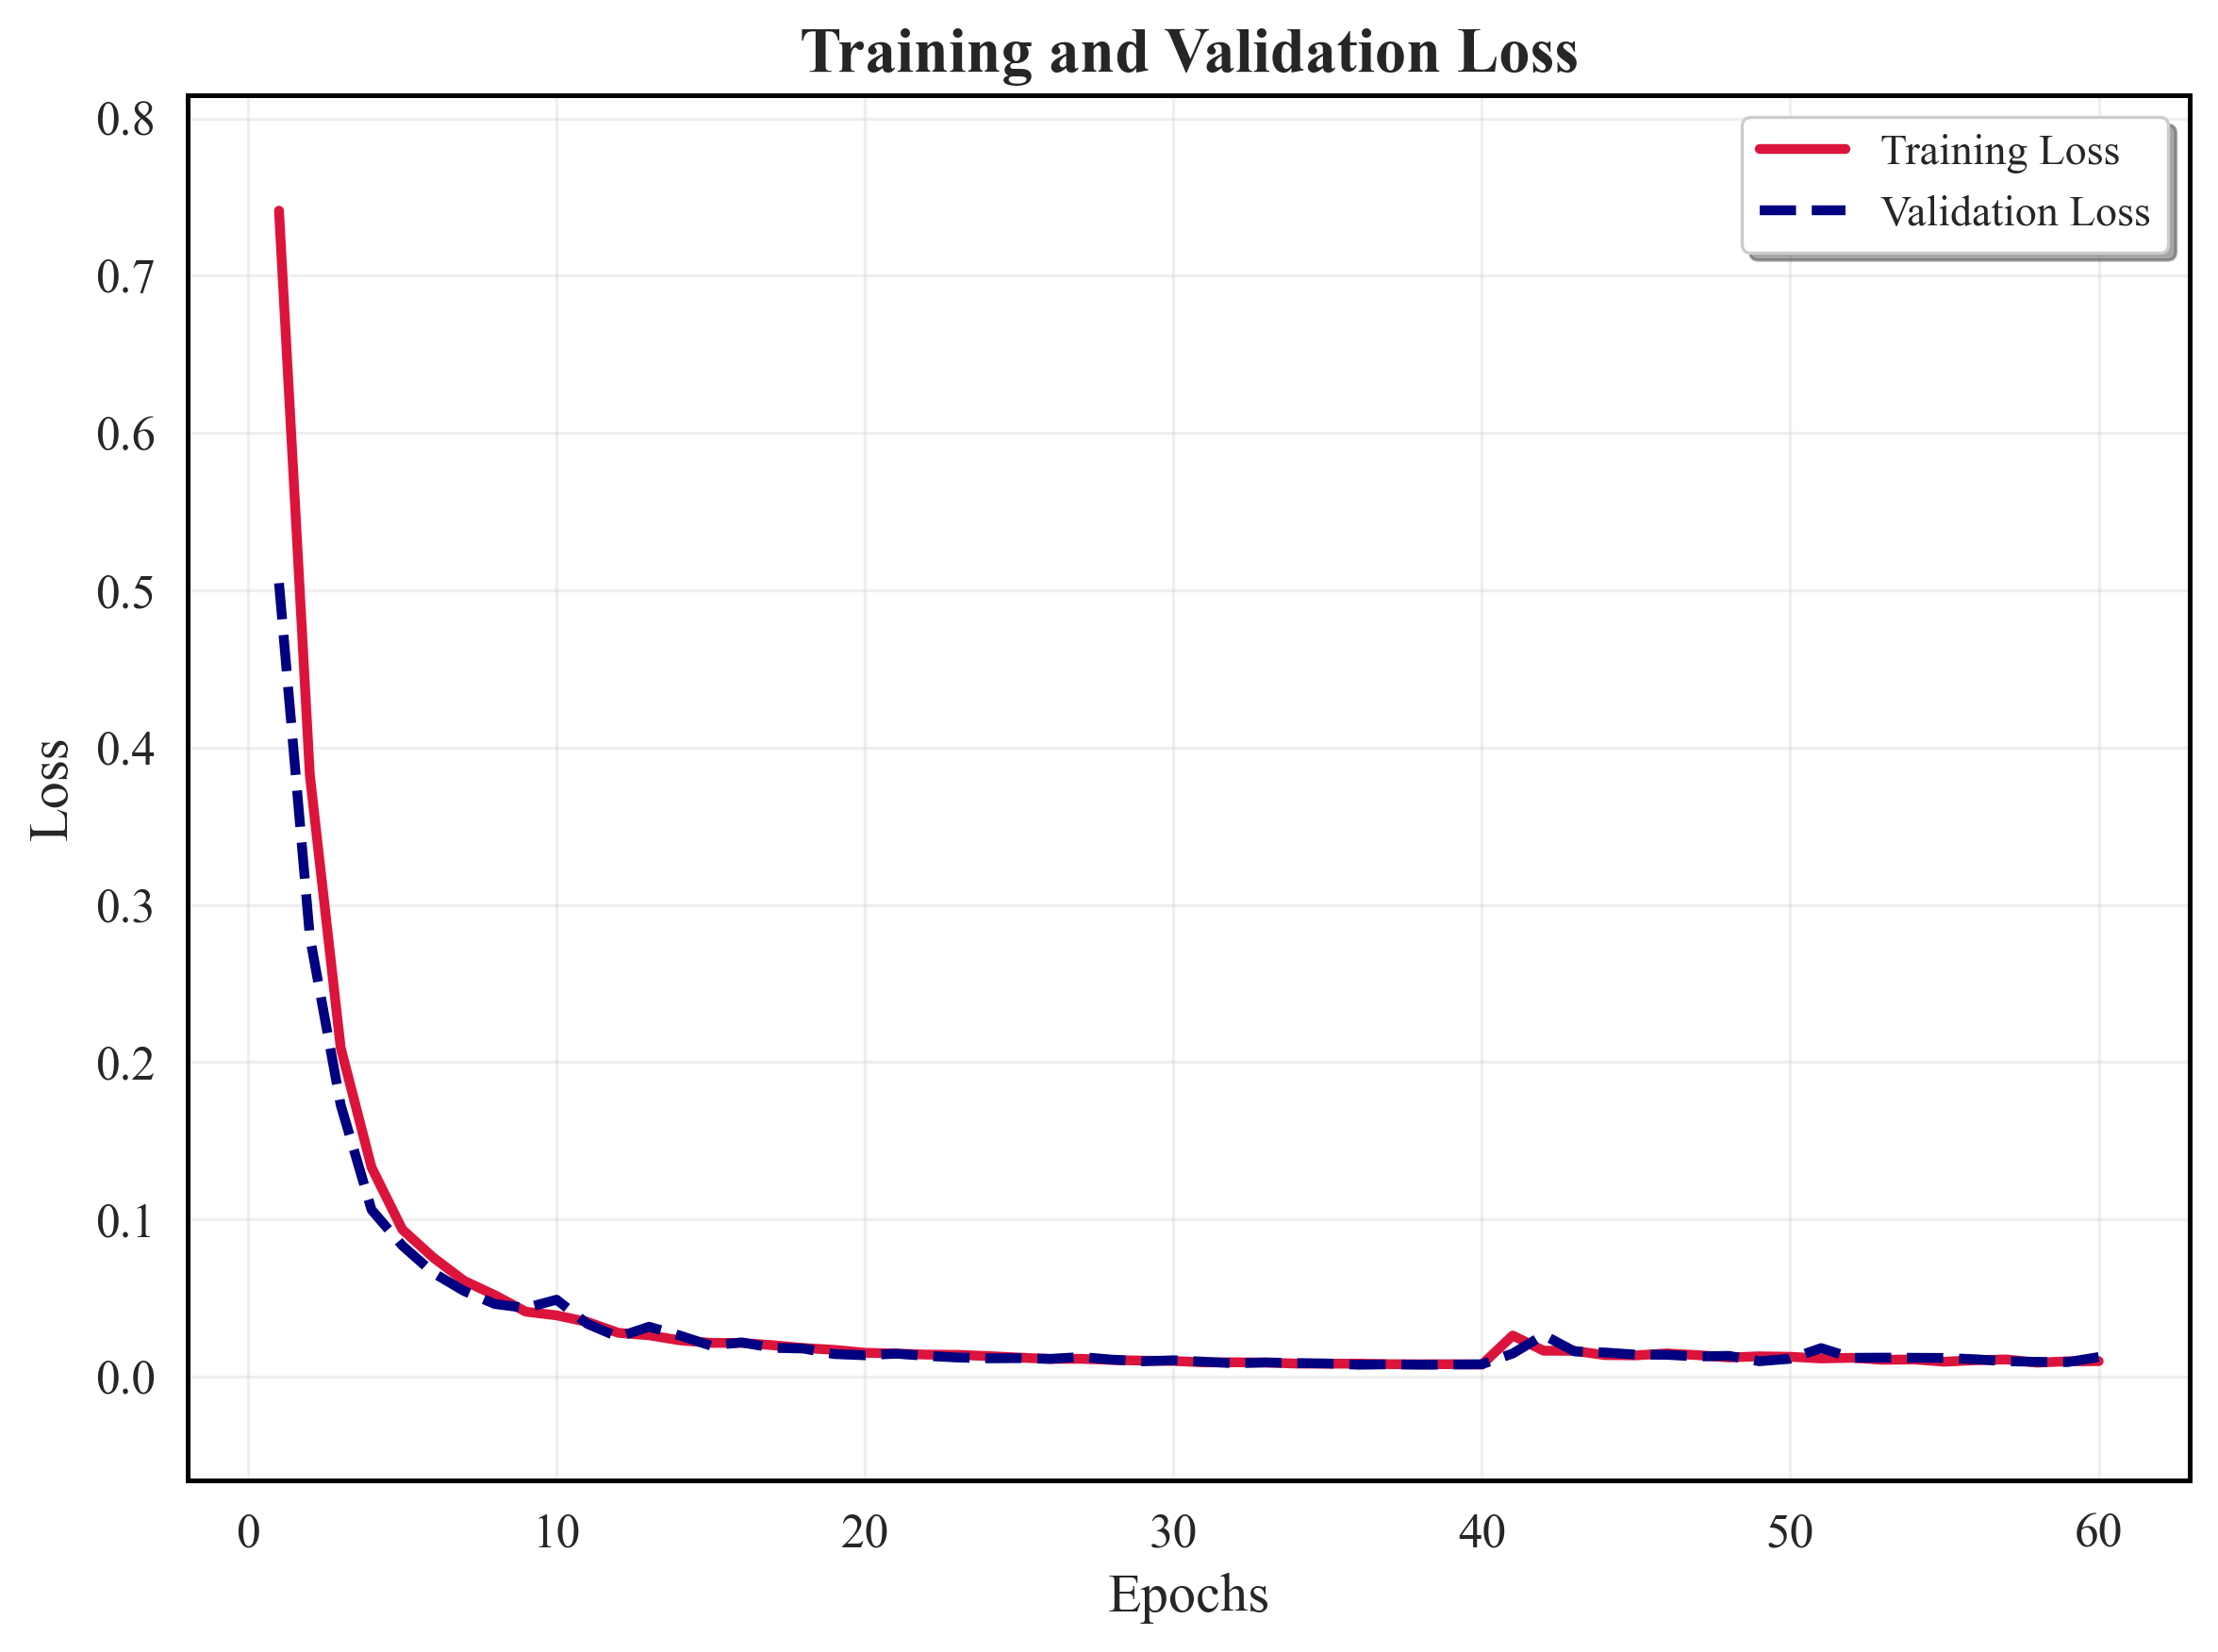

In [ ]:
set_seed( HP['seed']) # set seed for reproducibility    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Creating Dataloader ## 
images = np.load(data_dir) # (num_samples,64,64)
shuffled_indices = np.random.permutation(len(images))
images = images[shuffled_indices]
images = images.astype(np.float32) # (num_samples,64,64)

train_size = int(train_ratio*len(images))
val_size = len(images) - train_size 

train_images = images[:train_size]
val_images = images[train_size:]

# Normalizing the images using global mean and std
train_mean = np.mean(train_images)
train_std = np.std(train_images)
epsilon = 1e-8
train_images = (train_images - train_mean) / (train_std + epsilon)
val_images = (val_images - train_mean) / (train_std + epsilon)

train_images = torch.from_numpy(train_images).unsqueeze(1)  # (num_train_samples,1,64,64)
val_images = torch.from_numpy(val_images).unsqueeze(1)  # (num_val_samples,1,64,64)

train_dataset = TensorDataset( train_images )
val_dataset = TensorDataset( val_images )

train_dataloader = DataLoader(train_dataset, batch_size=HP['batch_size'], shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=HP['batch_size'], shuffle=False)

## Creating Model ##
model = mae_vit_base_patch16_dec512d8b(img_size=64).to(device)

## Training ##
trainer = Trainer_pretrain(model, device, HP)
train_loss,val_loss = trainer.model_train(train_dataloader, val_dataloader)

## Printing Loss ##
plot_loss(train_loss,val_loss)



In [ ]:
# Saving the entire model
# torch.save(model, f'pretrainedMAE.pth')

# Saving only the model weights 
# torch.save(model.state_dict(), r'weights\pretrainedMAE_weights.pth')


##### *5.3 Inference* 

In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = mae_vit_base_patch16_dec512d8b(img_size=64).to(device)
model.load_state_dict(torch.load(r'weights\pretrainedMAE_weights.pth'))

nosub_dir = r'dataset\no_sub'
display_prediction(model, nosub_dir, train_mean, train_std,device , colormap='viridis')
# Note : display_prediction(.) is producing the images in quality "dpi=1000" so it might
# take a while to render the images. For quick rendering, you can set dpi=100 in the function.

C:\Users\Admin\AppData\Local\Temp\ipykernel_15608\3454260831.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(r'saved_models\best_model_60epochs_zscore

**Note:** Artifacts in the unmasked regions of the **Predicted Reconstruction** arise because the loss function penalizes only the reconstruction of masked patches.


$$
\mathcal{L}_{\text{MAE}} = \frac{1}{\sum_{i=1}^L m_i} \sum_{i=1}^L m_i \cdot \left\| \hat{x}_i - x_i \right\|_2^2 \\\\
$$

$$
\begin{aligned}
&\text{where } m_i \in \{0, 1\} \text{ indicates whether patch } i \text{ is masked (1) or not (0),} \\
&\hat{x}_i \text{ is the predicted embedding of patch } i, \\
&x_i \text{ is the ground truth embedding of patch } i.
\end{aligned}
$$

